# iForest

In [426]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [427]:
import os
import sys

import pandas as pd
import numpy as np

import shap
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from os.path import join
import json
import datetime

### Load enviroment variables

In [428]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

## Examples for the paper

In [429]:
# Example usage:
data1 = np.array([
    [8, 2, 6, 5, 4, 3, 7, 1],
    [5, 8, 3, 6, 7, 4, 1, 2],
    [1, 6, 8, 7, 2, 5, 4, 3],
    [7, 4, 3, 2, 8, 1, 6, 5],
    [4, 6, 2, 3, 1, 7, 5, 8],
])

data2 = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8],
    [1, 2, 3, 4, 5, 6, 8, 7],
    [1, 2, 3, 4, 6, 5, 8, 8],
    [2, 1, 4, 3, 5, 6, 7, 8],
    [1, 3, 2, 4, 5, 6, 7, 8],
])


shap_values = np.array([[0.13, 0.08, 0.07, 0.05, 0.03, -0.03, -0.04, -0.05]])

In [430]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_dual_heatmaps(data1, data2):
    """
    Plots two heatmaps side by side for the given datasets.

    Parameters:
    - data1: numpy array for the first heatmap.
    - data2: numpy array for the second heatmap.
    """
    # Define row and column names based on the shape of data1 (assuming both datasets have the same shape)
    rows = [f'Iteration {i+1}' for i in range(data1.shape[0])]
    columns = [f'Feature {i+1}' for i in range(data1.shape[1])]

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # Set up a subplot grid that has 1 row and 2 columns

    # Plotting the first heatmap
    sns.heatmap(data1, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", cbar=False, xticklabels=columns, yticklabels=rows, ax=axs[0])
    axs[0].set_title("Anomaly Feature Rank at Each Iteration")
    axs[0].set_xlabel("Features")
    axs[0].set_ylabel("Iterations")

    # Plotting the second heatmap
    sns.heatmap(data2, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", cbar=False, xticklabels=columns, yticklabels=rows, ax=axs[1])
    axs[1].set_title("Anomaly Feature Rank at Each Iteration")
    axs[1].set_xlabel("Features")
    axs[1].set_ylabel("Iterations")

    plt.tight_layout()  # Adjust layout to fit row and column labels
    plt.show()


In [431]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def generate_and_combine_shap_plots(data1, shap_values, label):
    # Tus valores de SHAP y valores esperados
    expected_values = [0.35, 0.36, 0.37, 0.34, 0.33]

    # Generación de nombres de características a partir de data1
    feature_names = [[f'Feature {feature}' for feature in row] for row in data1]

    plot_paths = []

    for i, (expected_value, feature_names_set) in enumerate(zip(expected_values, feature_names), start=1):
        plt.figure()
        plot_path = f'../shap_plot_{label}_{i}.png'  # Asegúrate de usar una ruta accesible
        # Intenta ajustar aquí para menos espacio en blanco, aunque puede tener un efecto limitado
        shap.force_plot(expected_value, shap_values[0], feature_names_set, show=False, matplotlib=True).savefig(plot_path, bbox_inches='tight')
        plt.close()
        plot_paths.append(plot_path)

    # Combinación de todas las imágenes guardadas en una sola
    images = [Image.open(x) for x in plot_paths]
    widths, heights = zip(*(i.size for i in images))

    total_height = sum(heights)
    max_width = max(widths)

    combined_image = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for im in images:
        combined_image.paste(im, (0, y_offset))
        y_offset += im.size[1]

    combined_image_path = f'../combined_shap_plots_{label}.png'
    combined_image.save(combined_image_path)

    # Eliminación de los archivos de trama individuales
    for plot_path in plot_paths:
        os.remove(plot_path)

    # Devolución de la imagen combinada
    return Image.open(combined_image_path)


In [432]:
from PIL import Image, ImageDraw, ImageFont

def combine_images_with_titles(data1, data2, shap_values, title_left, title_right, font_size=20, gap=10):
    img_left = generate_and_combine_shap_plots(data1, shap_values, 'data1')  # Assuming this returns an Image object
    img_right = generate_and_combine_shap_plots(data2, shap_values, 'data2')  # Assuming this returns an Image object
    
    # Calculate dimensions for the new image
    max_height = max(img_left.height, img_right.height)
    # Adjust total_width to include a gap if desired
    total_width = img_left.width + img_right.width - gap

    # Adjusting font settings
    font_name = "Helvetica.ttc"  # Helvetica is usually available on macOS
    font_path = f"/System/Library/Fonts/{font_name}"
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print("Fallback to default font")
        font = ImageFont.load_default()

    # Measure text to determine additional height needed
    draw = ImageDraw.Draw(img_left)  # Dummy draw object to measure text size
    text_height_left = draw.textsize(title_left, font=font)[1]
    text_height_right = draw.textsize(title_right, font=font)[1]
    additional_height = max(text_height_left, text_height_right) + 10  # Add a little padding

    # Create a new image with adjusted height for titles
    new_img = Image.new('RGB', (total_width, max_height + additional_height), 'white')

    # Paste the original images into the new image at adjusted positions
    # Adjust the position of the right image to account for the desired gap
    new_img.paste(img_left, (0, additional_height))
    # Calculate the position for the right image to include the gap
    right_img_x_position = img_left.width - gap
    new_img.paste(img_right, (right_img_x_position, additional_height))

    # Draw the titles in the new adjusted positions
    draw = ImageDraw.Draw(new_img)
    draw.text(((img_left.width - draw.textsize(title_left, font=font)[0]) // 2, 0), title_left, fill="black", font=font)
    draw.text(((total_width + right_img_x_position - draw.textsize(title_right, font=font)[0]) // 2, 0), title_right, fill="black", font=font)

    # Save or display the combined image
    new_img_path = '../shap_example.png'  # Adjust as necessary
    new_img.save(new_img_path)

    return new_img_path


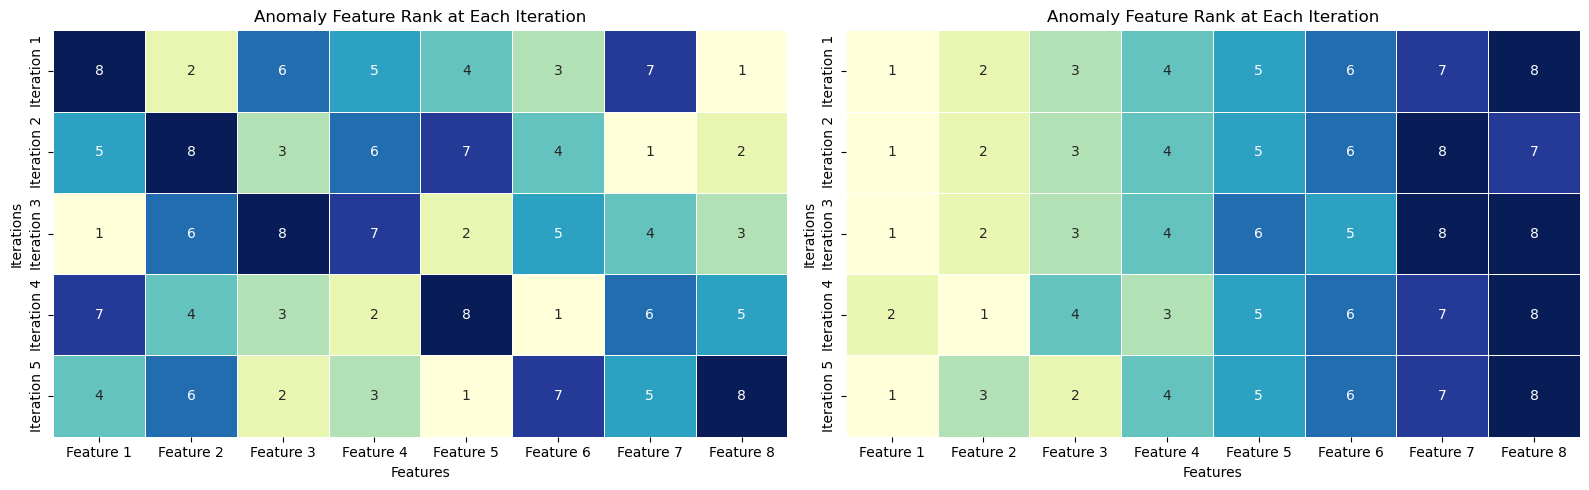

In [433]:
plot_dual_heatmaps(data1, data2)

In [434]:
# Example usage
title_left = 'Local-Interpretability at Each Iteration'
title_right = 'Local-Interpretability at Each Iteration'
combined_image_path = combine_images_with_titles(data1, data2, shap_values, title_left, title_right, gap=1)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

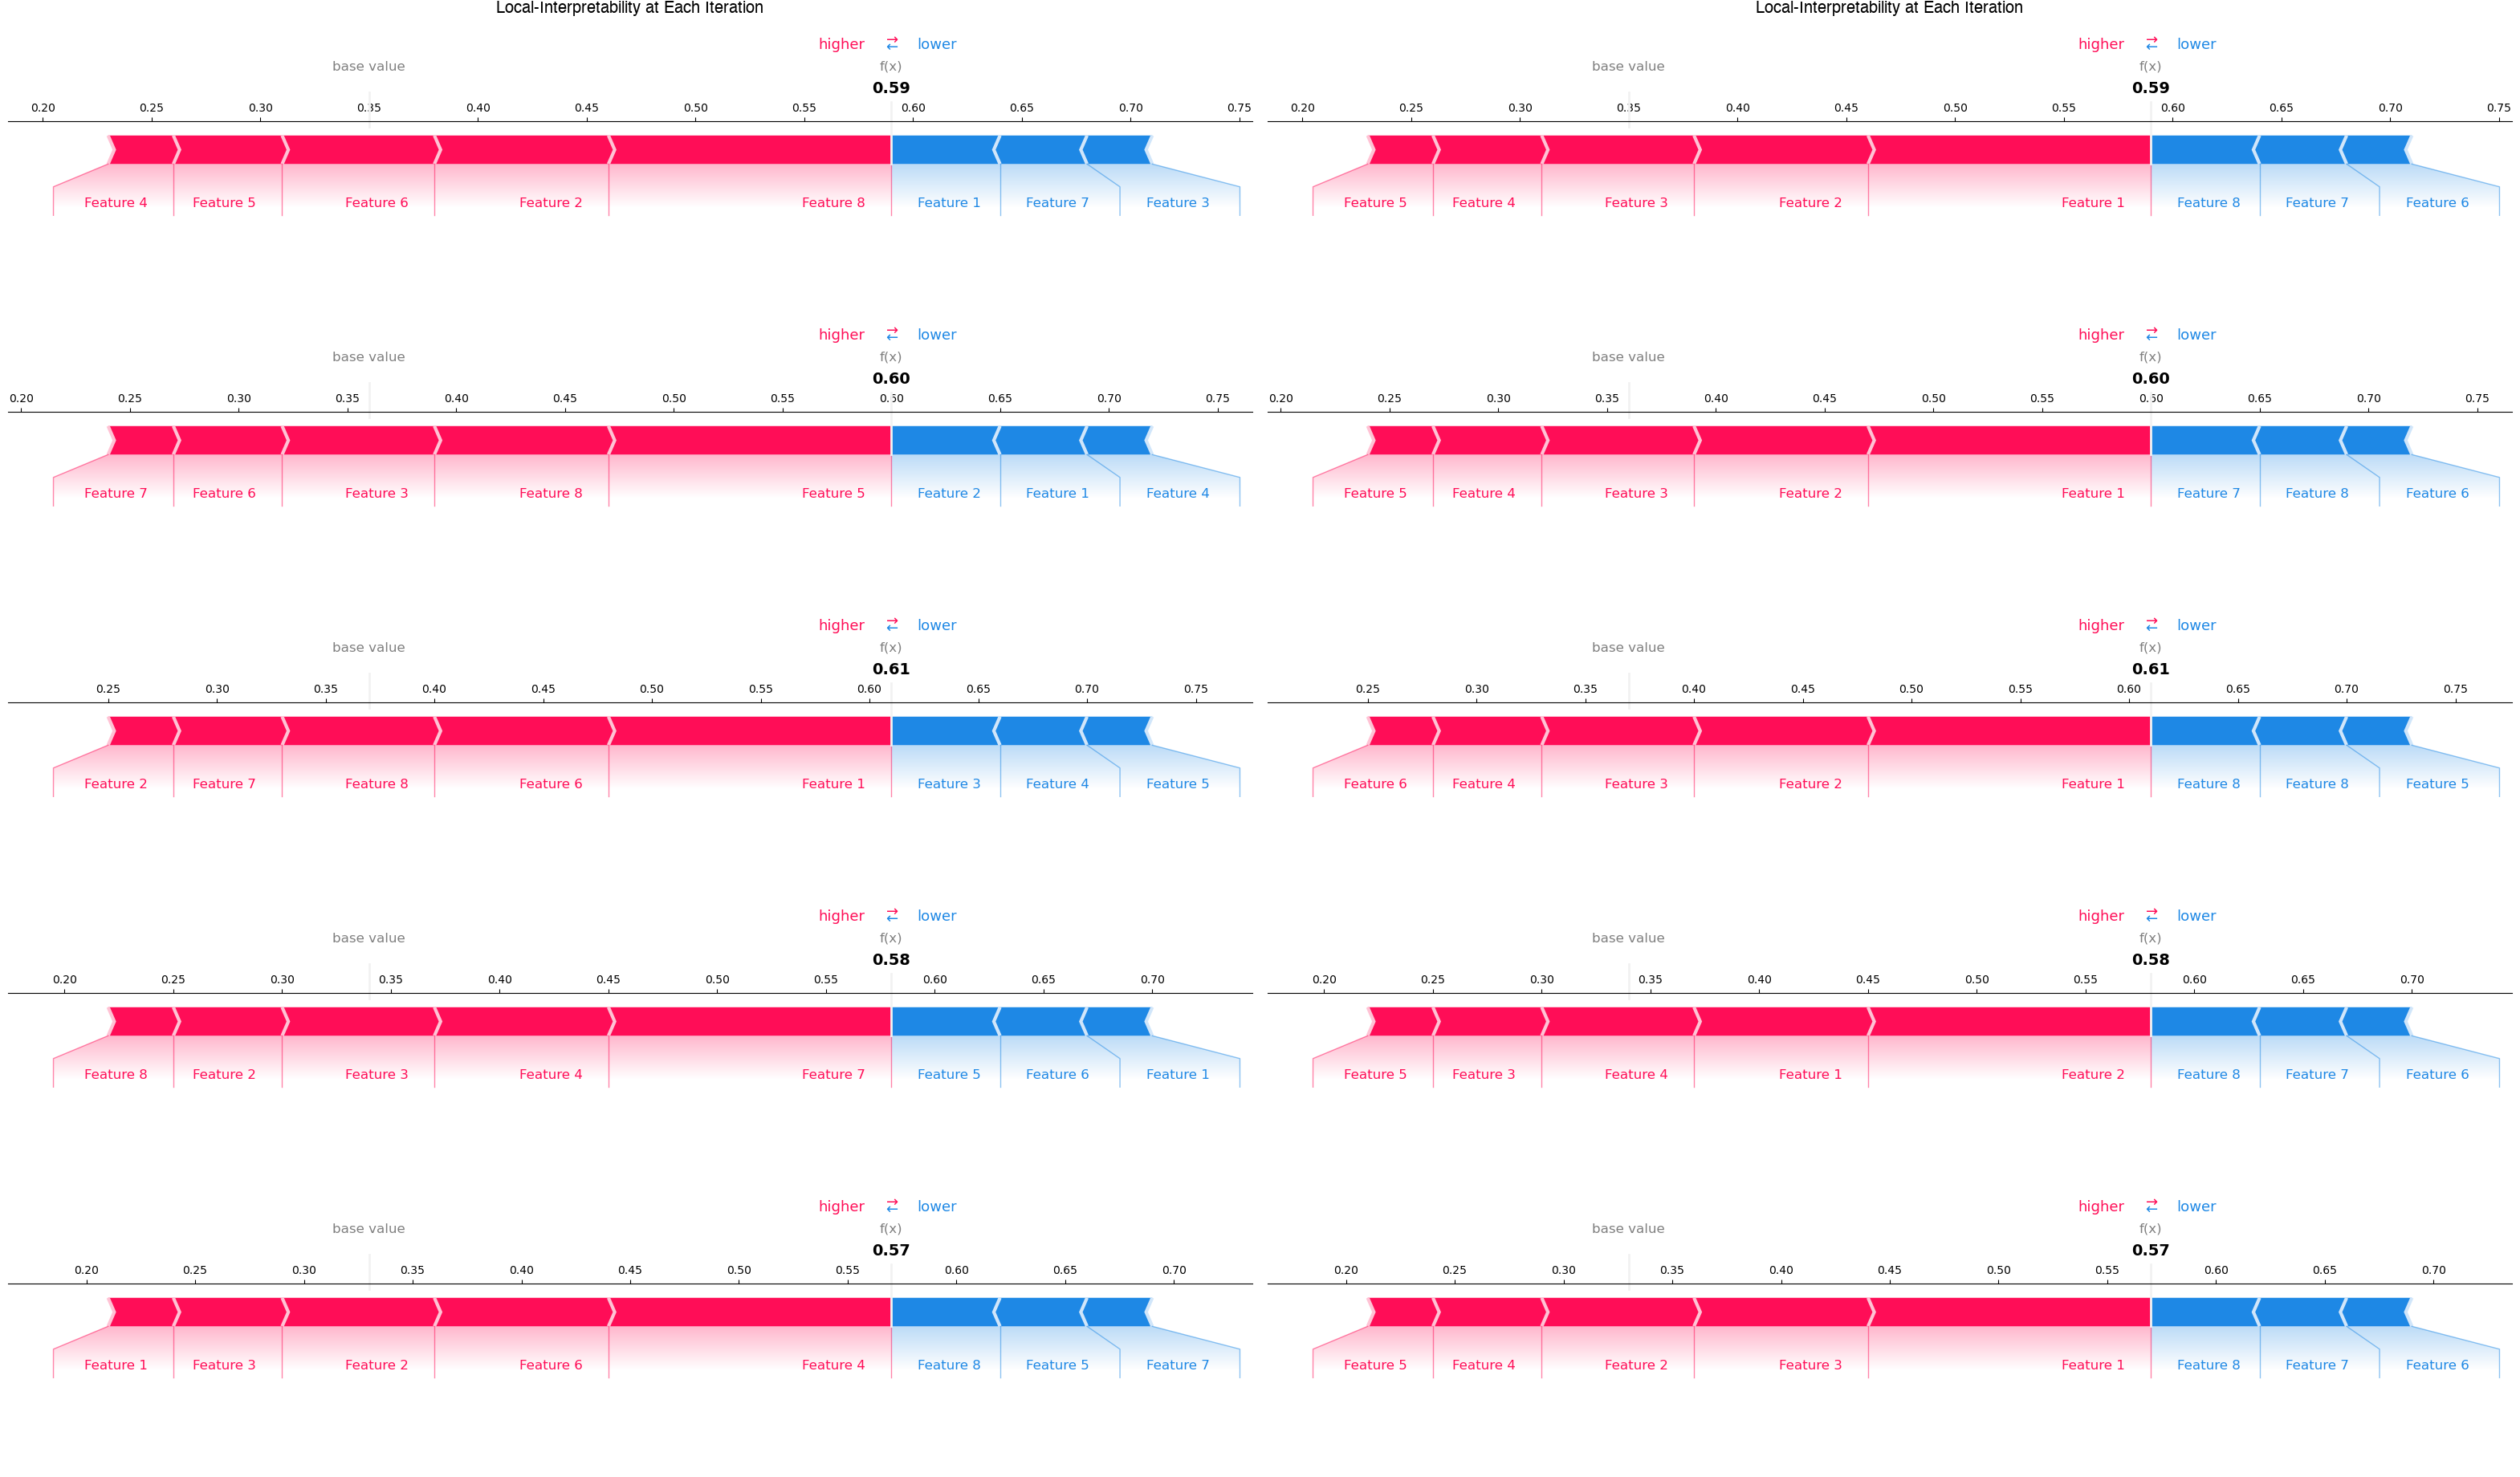

In [435]:
# Save or display the combined image
combined_image_path = '../shap_example.png'  # Adjust as necessary
Image.open(combined_image_path)

In [436]:
def add_custom_repeating_sequence(df, new_column_name, sequence_length):
    """
    Adds a new column to the DataFrame with a custom repeating sequence of numbers.

    Parameters:
    - df: Pandas DataFrame to which the column will be added.
    - new_column_name: The name of the new column.
    - sequence_length: The length of the sequence to repeat (e.g., 5 for a sequence of 1 to 5).

    Returns:
    - The DataFrame with the added column.
    """
    total_length = len(df)
    repeat_full = total_length // sequence_length
    remainder = total_length % sequence_length

    # Create the repeating sequence
    sequence_full = np.tile(np.arange(1, sequence_length + 1), repeat_full)
    sequence_remainder = np.arange(1, remainder + 1)
    new_column = np.concatenate([sequence_full, sequence_remainder])

    # Add the new column to the DataFrame
    df[new_column_name] = new_column
    return df


def create_repeating_sequence(end_number, repeat_times):
    """
    Creates a list with a sequence of numbers where each number repeats
    a specified number of times until reaching the end number.

    Parameters:
    - end_number: The last number in the sequence.
    - repeat_times: How many times each number should repeat.

    Returns:
    - A list with the repeating sequence.
    """
    sequence = []
    for num in range(1, end_number + 1):
        sequence.extend([num] * repeat_times)
    return sequence


import pandas as pd
import numpy as np

def create_repeating_sequence(end_number, repeat_times):
    """
    Creates a list with a sequence of numbers where each number repeats
    a specified number of times until reaching the end number.

    Parameters:
    - end_number: The last number in the sequence.
    - repeat_times: How many times each number should repeat.

    Returns:
    - A list with the repeating sequence.
    """
    sequence = []
    for num in range(1, end_number + 1):
        sequence.extend([num] * repeat_times)
    return sequence

def add_sequence_to_dataframe(df, sequence, column_name):
    """
    Adds a sequence as a new column to the DataFrame, repeating it until the end of the DataFrame.

    Parameters:
    - df: The DataFrame to which the sequence will be added.
    - sequence: The sequence to add as a new column.
    - column_name: The name of the new column.

    Returns:
    - The DataFrame with the new column added.
    """
    total_length = len(df)
    repeat_full = total_length // len(sequence)
    remainder = total_length % len(sequence)

    full_sequence = sequence * repeat_full + sequence[:remainder]
    
    df[column_name] = full_sequence
    return df

In [437]:
# Arrhythmia
dataset_id = 'arrhythmia'

path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)
df = df[(df.n_estimators>=25) & (df.n_estimators<=300)]

df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))

df['shap_mean'] = df['shap_stab'].apply(lambda x: np.mean(x))
df['shap_variance'] = df['shap_stab'].apply(lambda x: np.var(x))

df = df.sort_values(by=['n_estimators', 'n_feats', 'max_feats'], ascending=[True, False, False])

df = add_custom_repeating_sequence(df, 'rank_max_feats', 5)
df['rank_estimators'] = df.groupby(['n_feats', 'rank_max_feats']).cumcount() + 1
sequence = create_repeating_sequence(11, 5)
df = add_sequence_to_dataframe(df, sequence, 'rank_feats')

In [438]:
df01 = df[(df['rank_feats']==1) & (df['rank_max_feats']==1)]
df02 = df[(df['rank_feats']==1) & (df['rank_max_feats']==2)]
df03 = df[(df['rank_feats']==1) & (df['rank_max_feats']==3)]
df04 = df[(df['rank_feats']==1) & (df['rank_max_feats']==4)]
df05 = df[(df['rank_feats']==1) & (df['rank_max_feats']==5)]

df01 = df01.explode('shap_stab')
df02 = df02.explode('shap_stab')
df03 = df03.explode('shap_stab')
df04 = df04.explode('shap_stab')
df05 = df05.explode('shap_stab')

df01['shap_stab'] = pd.to_numeric(df01['shap_stab'])
df02['shap_stab'] = pd.to_numeric(df02['shap_stab'])
df03['shap_stab'] = pd.to_numeric(df03['shap_stab'])
df04['shap_stab'] = pd.to_numeric(df04['shap_stab'])
df05['shap_stab'] = pd.to_numeric(df05['shap_stab'])

############################################################

df11 = df[(df['rank_feats']==2) & (df['rank_max_feats']==1)]
df12 = df[(df['rank_feats']==2) & (df['rank_max_feats']==2)]
df13 = df[(df['rank_feats']==2) & (df['rank_max_feats']==3)]
df14 = df[(df['rank_feats']==2) & (df['rank_max_feats']==4)]
df15 = df[(df['rank_feats']==2) & (df['rank_max_feats']==5)]

df11 = df11.explode('shap_stab')
df12 = df12.explode('shap_stab')
df13 = df13.explode('shap_stab')
df14 = df14.explode('shap_stab')
df15 = df15.explode('shap_stab')

df11['shap_stab'] = pd.to_numeric(df11['shap_stab'])
df12['shap_stab'] = pd.to_numeric(df12['shap_stab'])
df13['shap_stab'] = pd.to_numeric(df13['shap_stab'])
df14['shap_stab'] = pd.to_numeric(df14['shap_stab'])
df15['shap_stab'] = pd.to_numeric(df15['shap_stab'])


##############################################################

df21 = df[(df['rank_feats']==4) & (df['rank_max_feats']==1)]
df31 = df[(df['rank_feats']==6) & (df['rank_max_feats']==1)]
df41 = df[(df['rank_feats']==8) & (df['rank_max_feats']==1)]
df51 = df[(df['rank_feats']==10) & (df['rank_max_feats']==1)]

df21 = df21.explode('shap_stab')
df31 = df31.explode('shap_stab')
df41 = df41.explode('shap_stab')
df51 = df51.explode('shap_stab')

df21['shap_stab'] = pd.to_numeric(df21['shap_stab'])
df31['shap_stab'] = pd.to_numeric(df31['shap_stab'])
df41['shap_stab'] = pd.to_numeric(df41['shap_stab'])
df51['shap_stab'] = pd.to_numeric(df51['shap_stab'])

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def boxplot_stability(df0, df1, fontsize=8, save_path='../boxplots.png'):
    """
    Generates a 3x3 grid of plots for comparing stability metrics.

    Parameters:
    - df0: DataFrame without feature selection.
    - df1: DataFrame with feature selection.
    - fontsize: Font size for plot text elements.
    """
    plt.figure(figsize=(24, 12))  # Overall figure size
    fontsize = 15
    fontsize_x = 10
    row = 2
    # Plot 1: SHAP Stability vs Number of Estimators (Without FS)
    plt.subplot(row, 2, 1)
    sns.boxplot(data=df0, x='n_estimators', y='shap_stab', color='steelblue')
    sns.boxplot(data=df0, x='n_estimators', y='shap_stab', color='steelblue')
    plt.xticks(fontsize=fontsize_x)
    plt.title('Stability vs Number of Estimators (Without FS)', fontsize=fontsize)
    plt.xlabel('Number of Estimators', fontsize=fontsize)
    plt.ylabel('Stability', fontsize=fontsize)

    # Plot 2: SHAP Stability vs Number of Estimators (With FS)
    plt.subplot(row, 2, 2)
    sns.boxplot(data=df1, x='n_estimators', y='shap_stab', color='skyblue')
    plt.xticks(fontsize=fontsize_x)
    plt.title('Stability vs Number of Estimators (With FS)', fontsize=fontsize)
    plt.xlabel('Number of Estimators', fontsize=fontsize)
    plt.ylabel('Stability', fontsize=fontsize)

    plt.tight_layout()  # Adjust layout
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the plot to free up memory

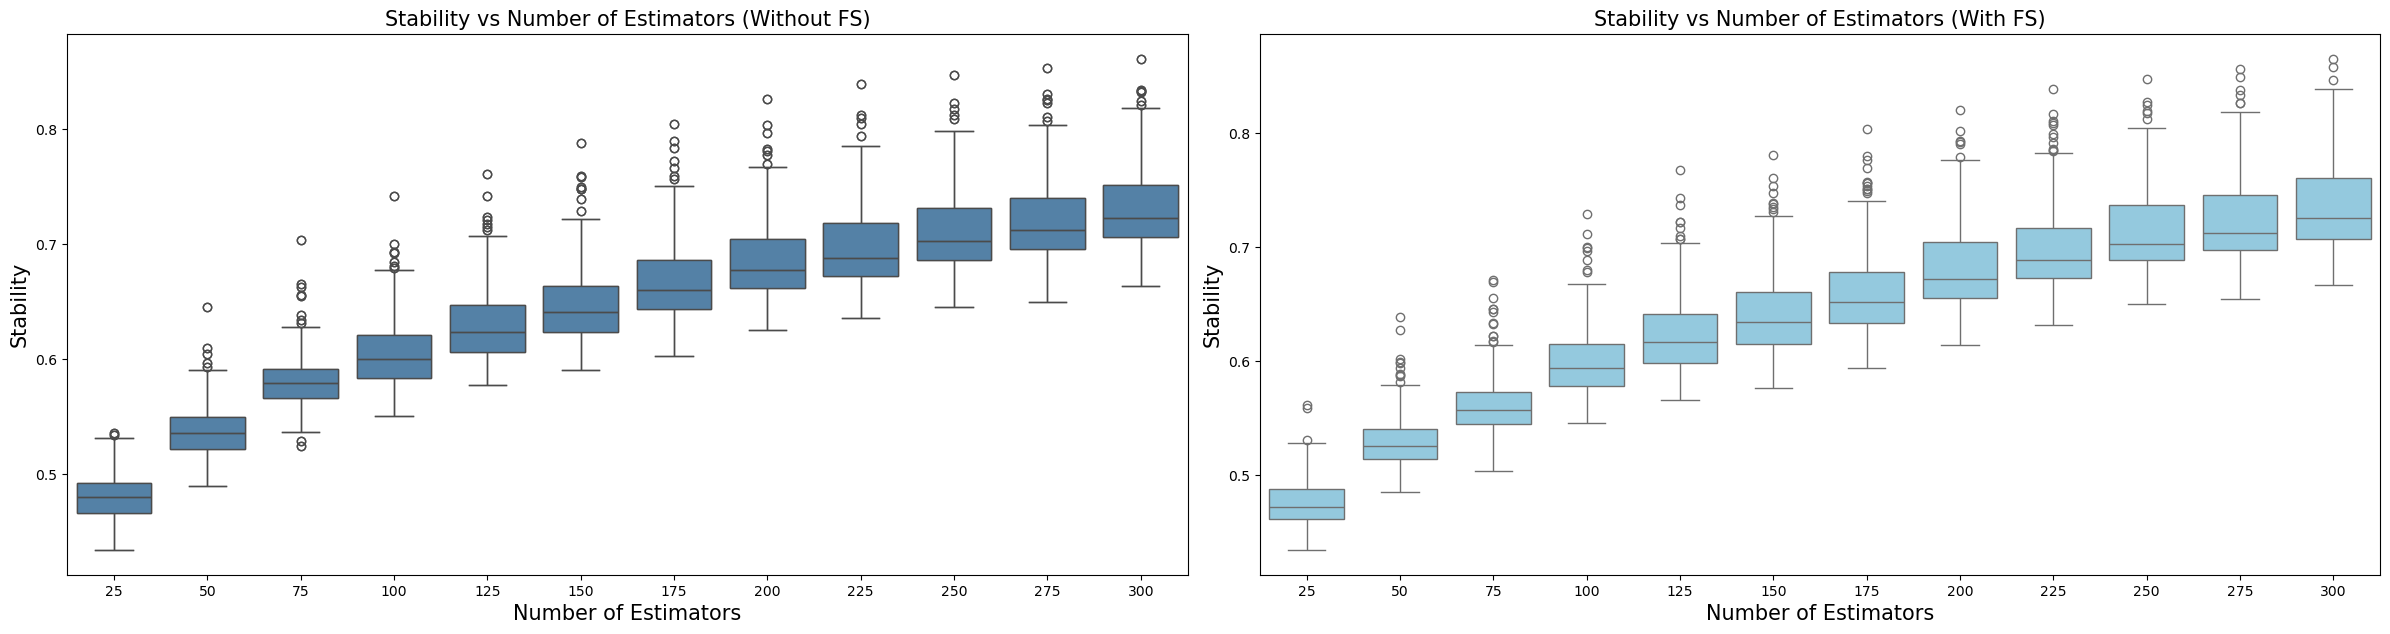

In [457]:
boxplot_stability(df01, df11)

In [465]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def lineplot_stability(dataframes, fontsize=8, save_path='../rocavgstab.png'):
    """
    Generates a 3x3 grid of plots for comparing stability metrics.

    Parameters:
    - df0: DataFrame without feature selection.
    - df1: DataFrame with feature selection.
    - fontsize: Font size for plot text elements.
    """
    plt.figure(figsize=(20, 9))  # Overall figure size
    fontsize = 12
    fontsize_x = 10
    fontsize_label = 7
    row = 2

    colors = ['steelblue', 'skyblue', 'green', 'orange', 'yellow', 'purple']
    labels = ['Without FS', 'With FS-100%', 'With FS-80%', 'With FS-60%', 'With FS-40%', 'With FS-20%']
    
    # Plot 4: Mean SHAP Stability vs Number of Estimators and Max features selected    
    plt.subplot(row, 2, 2)
    for df, color, label in zip(dataframes, colors, labels):
        sns.pointplot(data=df, x='n_estimators', y='shap_mean', color=color, markers='', linestyles='--', ci=None, label=label)
    
    plt.title('Mean Stability vs Number of Estimators', fontsize=fontsize)
    plt.xlabel('Number of Estimators', fontsize=fontsize)
    plt.ylabel('Mean Stability', fontsize=fontsize)
    plt.legend(title='Criteria', fontsize=fontsize_label, loc='lower right', ncol=3)

    # Plot 8: Mean SHAP Stability vs Number of Estimators and Max features selected
    plt.subplot(row, 2, 1)
    for df, color, label in zip(dataframes, colors, labels):
        sns.pointplot(data=df, x='n_estimators', y='roc_auc', color=color, markers='', linestyles='--', ci=None, label=label)
    
    plt.title('AUPRC vs Number of Estimators', fontsize=fontsize)
    plt.xlabel('Number of Estimators', fontsize=fontsize)
    plt.ylabel('ROC', fontsize=fontsize)
    plt.legend(title='Criteria', fontsize=fontsize_label, loc='lower right', ncol=3)

    plt.tight_layout()  # Adjust layout
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the plot to free up memory

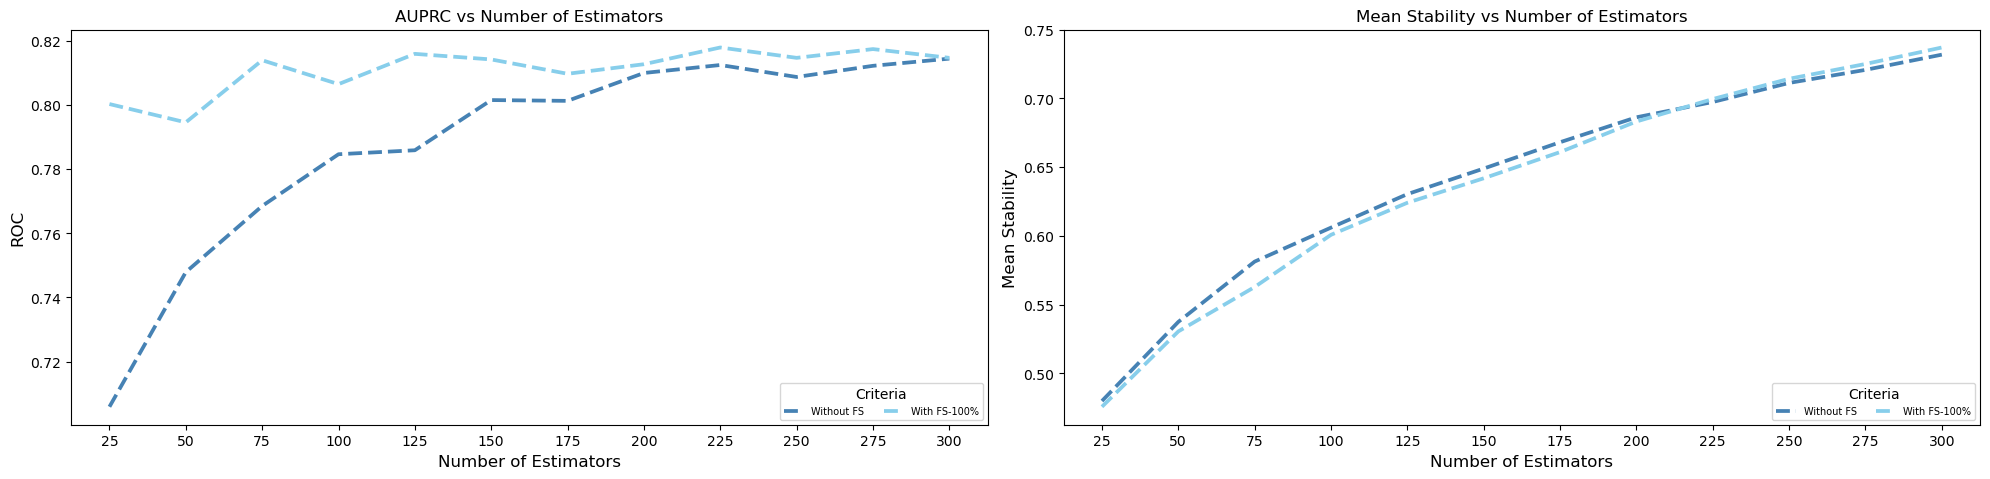

In [466]:
dataframes = [df01, df11] #, df21, df31, df41, df51

lineplot_stability(dataframes)

In [ ]:
# Create a table comparative
# We compare the results again a dataset where they use a benchmark of anomaly detection model and the best one is 
# isolation forest and they use the arrhythmia dataset with the following HPO. 257 features and 257 max_samples and 100 n_estimators.

# We could check if we replicate their results:
# ROC
# Presicion
# Recall
# F1 score
# Stability Index for Local-Interpretability

#The results with the HPO proposed in the paper from XXX have this results
	n_estimators	n_feats	max_feats	roc_auc	precision	recall	f1_median	shap_mean
1539	100	257	257	0.784615	0.6	0.461538	0.521739	0.606028

# The results playing with the HPO and using a Feature selection method not just improve the traditionals metrics.
# Improve the shap stability index too
n_estimators	n_feats	max_feats	roc_auc	precision	recall	f1_median	shap_mean
1958	300	94	75	0.806948	0.619048	0.500000	0.553191	0.816824

In [420]:
df_compare = df[(df['rank_feats']==1) & (df['rank_max_feats']==1)]
df_compare = df_compare[(df_compare.n_estimators==100) & (df_compare.n_feats==257) & (df_compare.max_feats==257)]
var = ['n_estimators', 'n_feats', 'max_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'shap_mean']
df_compare[var]

,n_estimators,n_feats,max_feats,roc_auc,precision,recall,f1_median,shap_mean
1539,100,257,257,0.784615,0.6,0.461538,0.521739,0.606028


In [423]:
df[var][(df.roc_auc>=0.784615) & (df.precision>=0.6) & (df.recall>=0.461538) & (df.f1_median>=0.521739)].sort_values('shap_mean', ascending=False)

,n_estimators,n_feats,max_feats,roc_auc,precision,recall,f1_median,shap_mean
1958,300,94,75,0.806948,0.619048,0.500000,0.553191,0.816824
1849,250,94,94,0.814640,0.619048,0.500000,0.553191,0.790879
1791,225,94,37,0.805459,0.619048,0.500000,0.553191,0.787046
1794,225,94,94,0.817866,0.619048,0.500000,0.553191,0.780256
1739,200,94,94,0.818362,0.619048,0.500000,0.553191,0.768532
1968,300,152,121,0.809429,0.600000,0.461538,0.521739,0.756892
1681,175,94,37,0.801737,0.619048,0.500000,0.553191,0.756103
1684,175,94,94,0.815881,0.650000,0.500000,0.565217,0.750843
1913,275,152,121,0.811663,0.600000,0.461538,0.521739,0.745023
1910,275,152,30,0.803226,0.600000,0.461538,0.521739,0.742862


In [416]:
df_compare = df[(df['rank_feats']==1) & (df['rank_max_feats']==1)]
df_compare = df_compare[(df_compare.n_estimators==100) & (df_compare.n_feats==257) & (df_compare.max_feats==257)]
df_compare[['n_estimators', 'n_feats', 'max_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'shap_mean']]

Index(['n_estimators', 'max_feats', 'contamination', 'n_feats', 'n_iter',
       'n_iter_fs', 'roc_auc', 'model_stab', 'shap_stab', 'shap_stab_ad',
       'f1_median', 'recall', 'precision', 'confusion_matrix', 'shap_q1',
       'shap_q2', 'shap_q3', 'shap_mean', 'shap_variance', 'rank_max_feats',
       'rank_estimators', 'rank_feats'],
      dtype='object')